In [1]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import parquet
from unidecode import unidecode
import zipfile
import random
from transformers import BertTokenizer
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import torch
from torch.utils.data import DataLoader, TensorDataset

from src.features.functions_preprocessing import (
    plot_text_length_distribution,
    preprocess_articles,
    preprocess_summaries,
)
from src.models.rnn_encoder_decoder import *
from src.models.transformer import Transformer
from src.models.bert import BertSummary

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
def get_allowed_cpu_count():
    # Returns the number of CPU cores available for this process.
    try:
        return len(os.sched_getaffinity(0))
    except AttributeError:
        return os.cpu_count() or 1

cpu_count = get_allowed_cpu_count()
print(cpu_count)

128


# **Kaggle dataset**

In [5]:
!kaggle datasets download -d sbhatti/news-summarization

Dataset URL: https://www.kaggle.com/datasets/sbhatti/news-summarization
License(s): CC0-1.0
news-summarization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
with zipfile.ZipFile("news-summarization.zip", "r") as zip_ref:
    zip_ref.extractall("news-summarization")

In [7]:
news_data = pd.read_csv("news-summarization/data.csv")

In [8]:
news_data.head()

,Unnamed: 0,ID,Content,Summary,Dataset
0,0,f49ee725a0360aa6881ed1f7999cc531885dd06a,New York police are concerned drones could bec...,Police have investigated criminals who have ri...,CNN/Daily Mail
1,1,808fe317a53fbd3130c9b7563341a7eea6d15e94,By . Ryan Lipman . Perhaps Australian porn sta...,Porn star Angela White secretly filmed sex act...,CNN/Daily Mail
2,2,98fd67bd343e58bc4e275bbb5a4ea454ec827c0d,"This was, Sergio Garcia conceded, much like be...",American draws inspiration from fellow country...,CNN/Daily Mail
3,3,e12b5bd7056287049d9ec98e41dbb287bd19a981,An Ebola outbreak that began in Guinea four mo...,World Health Organisation: 635 infections and ...,CNN/Daily Mail
4,4,b83e8bcfcd51419849160e789b6658b21a9aedcd,By . Associated Press and Daily Mail Reporter ...,A sinkhole opened up at 5:15am this morning in...,CNN/Daily Mail


In [9]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

By . Snejana Farberov, Daily Mail Reporter and Associated Press . PUBLISHED: . 17:05 EST, 20 August 2013 . | . UPDATED: . 17:15 EST, 20 August 2013 . The Miami man accused of killing his wife and posting a photo of her dead body on Facebook  admitted to detectives that he shot his wife ‘six to eight times,’ according to a newly released police search warrant. The warrant reveals new details about Derek Medina’s confession to the killing of Jennifer Alfonso, 26, on August 8 including that detectives took two Samsung cellphones, three Dell computers and an iPad from the couple’s South Miami home after the shooting. The warrant asks for permission to look for evidence including electronics, and suggests that the Facebook confession and photo will be key evidence for prosecutors as they prepare for a likely grand-jury indictment. Derek Medina, who is charged with murder in the death of his wife Jennifer Alfonso, told detectives that he shot her 'six to eight times' The document also shows 

In [10]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [11]:
news_data = news_data[
    (lengths_article >= lengths_article.quantile(0.10))
    & (lengths_article <= lengths_article.quantile(0.90))
]

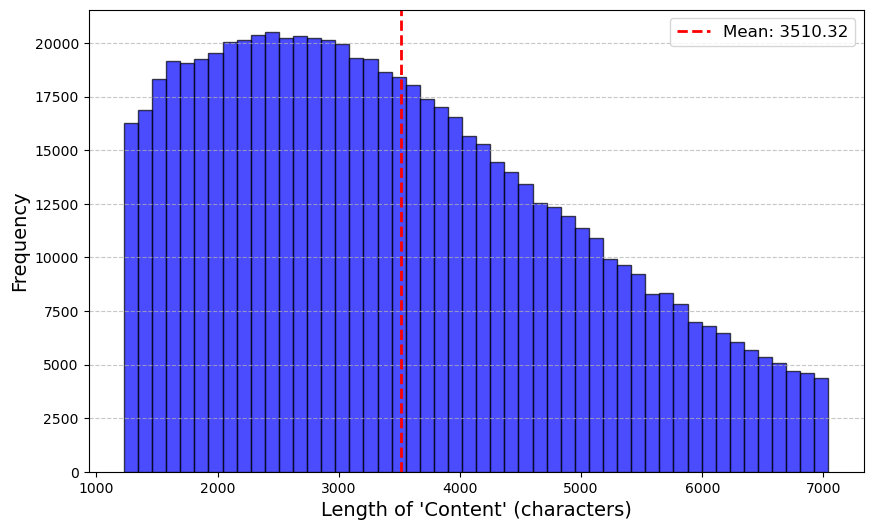

In [12]:
plot_text_length_distribution(news_data, "Content")

In [13]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    696451.000000
mean        283.484382
std         208.280906
min           1.000000
25%         163.000000
50%         247.000000
75%         326.000000
max        8541.000000
Name: Summary, dtype: float64

In [14]:
news_data = news_data[
    (lengths_summary >= lengths_summary.quantile(0.10))
    & (lengths_summary <= lengths_summary.quantile(0.90))
]

In [15]:
news_data["Summary"].str.len().describe()

count    558032.00000
mean        250.39556
std          78.90248
min         120.00000
25%         189.00000
50%         247.00000
75%         307.00000
max         435.00000
Name: Summary, dtype: float64

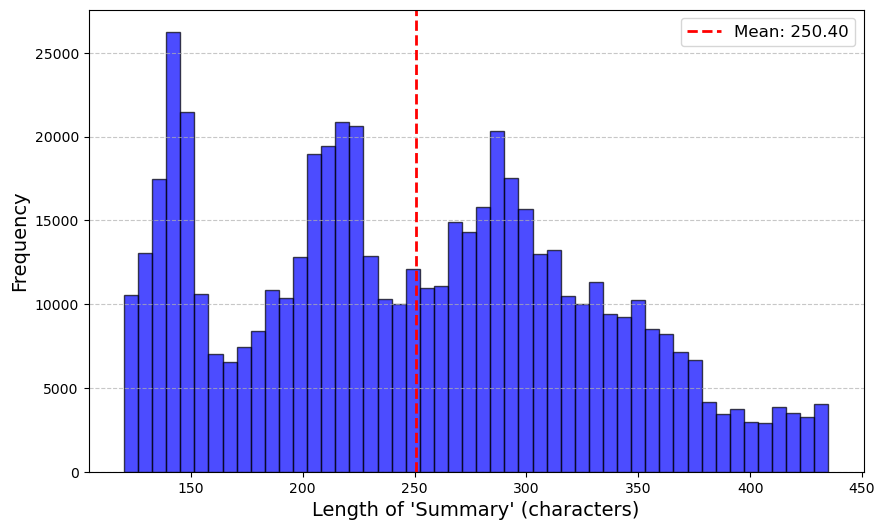

In [16]:
plot_text_length_distribution(news_data, "Summary")

In [17]:
len(news_data)

558032

In [ ]:
n_process = max(1, cpu_count // 4)
news_data.loc[:, "Content"] = preprocess_articles(news_data["Content"].tolist(), n_process = n_process, batch_size=32)
news_data.loc[:, "Summary"] = preprocess_summaries(news_data["Summary"].tolist(), n_process = n_process, batch_size=32)

In [ ]:
news_data.to_parquet("news_data_cleaned.parquet", index=False)

# **Tokenization**

In [ ]:
train_data = news_data[:200000]
# test_data = news_data[5000:6000]

In [ ]:
if __name__ == "__main__":
    texts_content = list(train_data["Content"])
    texts_summary = list(train_data["Summary"])

    print("Tokenizing Content...")
    tokenized_articles = parallel_tokenize(
        texts_content,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,  
        max_length=512
    )
    print("tokenized_articles.shape =", tokenized_articles.shape)
    torch.save(tokenized_articles, "tokenized_articles.pt")

    print("Tokenizing Summaries...")
    tokenized_summaries = parallel_tokenize(
        texts_summary,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=512
    )
    print("tokenized_summaries.shape =", tokenized_summaries.shape)
    torch.save(tokenized_summaries, "tokenized_summaries.pt")

In [ ]:
tokenized_articles = torch.load("tokenized_articles.pt")
tokenized_summaries = torch.load("tokenized_summaries.pt")

In [ ]:
tokenized_articles = tokenized_articles.long()

tokenized_summaries = torch.cat(
    [torch.zeros(tokenized_summaries.size(0), 1), tokenized_summaries], dim=1
).long()

article_ids = tokenized_articles.long()
summary_ids = tokenized_summaries.long()

# **RNN**

# **Transformer**

In [ ]:
batch_size = 10

dataset = TensorDataset(tokenized_articles, tokenized_summaries)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model_transformer = Transformer(
    pad_idx=0,
    voc_size=tokenizer.vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=512,
    dec_max_len=512,
    ffn_hidden=128,
    n_layers=3,
)

In [ ]:
num_epochs = 50

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=5e-4)
model = model_transformer.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):
        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch.long(), summary_batch[:, :-1])
        summary_batch = summary_batch[:, 1:]
        # Compute loss
        loss = loss_fn(
            outputs.reshape(-1, outputs.shape[-1]), summary_batch.reshape(-1)
        )
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step % 1000 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

# **BERT model**

In [ ]:
batch_size = 10

dataset = TensorDataset(tokenized_articles, tokenized_summaries[:, 1:])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
config = BertConfig(
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    vocab_size=tokenizer.vocab_size,
)

In [ ]:
model = BertSummary(config)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):

        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch, attention_mask=input_batch.ne(0))

        # Compute loss
        loss = loss_fn(outputs.view(-1, outputs.shape[-1]), summary_batch.view(-1))
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step % 1000 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

# **Evaluation**

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

bleu = evaluate.load("bleu")

In [ ]:
input_text = news_data["Content"][1000]

In [ ]:
tokenized_input = tokenizer.encode_plus(
    input_text,
    max_length=512,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)

In [ ]:
input_ids = tokenized_input["input_ids"].to(device)
attention_mask = tokenized_input["attention_mask"].to(device)

In [ ]:
model.eval()

In [ ]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

In [ ]:
# Reshape the outputs tensor
reshaped_outputs = outputs

# Get the predicted summary
predicted_summary_ids = torch.argmax(reshaped_outputs, dim=-1)
predicted_summary = tokenizer.decode(predicted_summary_ids[0], skip_special_tokens=True)

print("Predicted Summary:", predicted_summary)